<a href="https://colab.research.google.com/github/IamArmanNikkhah/ParsParaphraser/blob/main/ParsParaphraser_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the PARANMT-50M Dataset ☁

**Download the PARANMT-50M dataset**

In [ ]:
!gdown --id 1rbF3daJjCsa1-fu2GANeJd2FBXos1ugD

**Unzipping the Dataset**

In [ ]:
import zipfile

def unzip(zip_file, destination):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination)

unzip('/content/data/para-nmt-50m.zip', '/content/data')

**Displaying The dataset**

In [ ]:
def display_large_file(filename, line_num):
    """
    Display a large file.
    """
    with open(filename, 'r') as f:
        line_counter = 0
        for line in f:
            if line_counter > line_num:
              break
            print(line)
            line_counter +=1

display_large_file('/content/data/para-nmt-50m/para-nmt-50m.txt',5)

**Converting to CSV**

In [ ]:
import re

def remove_lines(file_name, pattern):
    with open(file_name, 'r') as f:
        lines = f.readlines()
    with open(file_name, 'w') as f:
        for line in lines:
            if len(re.findall(pattern, line)) == 2:
                f.write(line)

In [ ]:
remove_lines('/content/data/para-nmt-50m/para-nmt-50m.txt', '[.?"]\t["\d\w]')

**Download from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing PARANMT-50M Dataset ➰

In [ ]:
import pandas as pd
import numpy as np

**1)Finding empty cells  in each row**

In [ ]:
def empty_cells(df):
    """
    Returns a list of columns with empty cells and the number of them
    """
    empty_cells = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            empty_cells.append((col, df[col].isnull().sum()))
    return empty_cells

for chunk in pd.read_csv('/content/data/para-nmt-50m/para-nmt-50m.csv', chunksize=5000000):
  print(empty_cells(chunk))

**2)Droping rows with empty cells**

In [ ]:
def drop_empty_rows(df, column):
    return df.dropna(subset=[column])

for chunk in pd.read_csv('/content/data/para-nmt-50m/para-nmt-50m.csv', chunksize=5000000):
  drop_empty_rows(chunk, 'Similarity score')

**3) Droping Rows which their last column's cell isn't a number**

In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_rows_with_digits(df):
    return df[df.apply(lambda x: x[0].isdigit() or x[1].isdigit(), axis=1)]

def get_non_numeric_rows(df):
    return df[df.apply(lambda x: not is_number(x[-1]), axis=1)].index


for chunk in pd.read_csv('/content/data/para-nmt-50m/para-nmt-50m.csv', chunksize=1000000):
  chunk = chunk.drop(get_non_numeric_rows(chunk), inplace=False)
  chunk.to_csv('/content/data/para-nmt-50m/para-nmt-50m-preprocessed.csv',  index = None, mode='a')

**4) Selecting Rows with high similarity score**

In [ ]:
def drop_empty_rows(df, column):
    return df.dropna(subset=[column])

def get_rows_with_high_score(df, threshold = 0.85):
    return df[df['Similarity score'] > threshold]

def get_rows_with_last_column_greater_than_0_85_and_less_than_one(df):
    return df[(df.iloc[:,-1] > 0.85) & (df.iloc[:,-1] < 1)]

for chunk in pd.read_csv('/content/ParsParaphraser/para-nmt-50m-preprocessed.csv', chunksize=5000000):
    chunk.iloc[:, -1] = chunk.iloc[:, -1].replace('Similarity score', '0')
    chunk.iloc[:,-1]  = chunk.iloc[:,-1].astype(float)
    chunk = get_rows_with_last_column_greater_than_0_85_and_less_than_one(chunk)
    chunk.to_csv('/content/ParsParaphraser/para-nmt-final.csv',  index = None, mode='a')

**5) Load the dataframe into memory**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ParsParaphraser/para-nmt-final.csv')

**6) Removing rows with '0.' in them**

In [ ]:
import re
def check_string(string):
    if re.search(r'0\.[0-9]', string):
        return False
    else:
        return True

In [ ]:
df = df[df['Sentence'].apply(check_string) & df['Paraphrase'].apply(check_string)]

**7) Calculating word diffrence**

In [ ]:
def diff_words(str1, str2):
    str1_words = str1.split()
    str2_words = str2.split()
    return abs(len(str1_words) - len(str2_words))

In [ ]:
df['length diff'] = df.apply(lambda row: diff_words(row['Sentence'], row['Paraphrase']), axis=1)

**8) Finding outliers in length diffrence**

In [ ]:
df['length diff'].mean()

1.5001102174196121

In [ ]:
df['length diff'].std()

2.5684722989195357

In [ ]:
import matplotlib.pyplot as plt
df.boxplot(column=['length diff'])
plt.show()

In [ ]:
def find_outliners(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

df.drop(find_outliners(df, 'length diff').index.tolist(),  inplace=True)

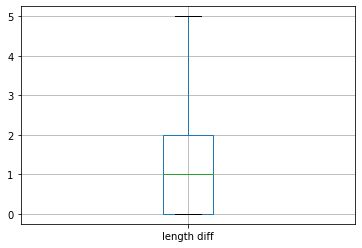

In [ ]:
df.boxplot(column=['length diff'])
plt.show()

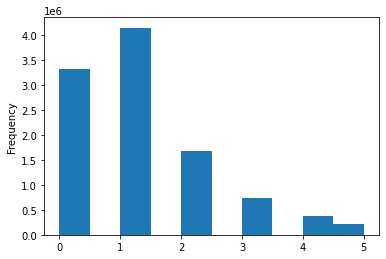

In [ ]:
df['length diff'].plot(kind='hist')
plt.show()

**9) Remove rows with a high ratio of numbers**

In [ ]:
def ratio(string):
    num = 0
    for i in string:
        if i.isdigit():
            num += 1
    percent = num / len(string)
    return percent

df['average num ratio'] = df.apply(lambda row: (ratio(row['Sentence']) + ratio(row['Paraphrase']))/2, axis=1)

In [ ]:
df['average num ratio'].mean()

0.005428928755714689

In [ ]:
df['average num ratio'].std()

0.023538055197032864

In [ ]:
df = df[df.iloc[:,-1]<=0.06]

**10) Remove rows with a high ratio of capital letters**

In [ ]:
df.drop('average capital ratio',axis=1,inplace=True)

In [ ]:
def count_capital_words(text):
    count = 0
    words = text.split()
    for word in words[1:]:
        if word[0].isupper():
            count += 1
    return count/len(text)

df['average capital ratio'] = df.apply(lambda row: (count_capital_words(row['Sentence']) + count_capital_words(row['Paraphrase']))/2, axis=1)

In [ ]:
df['average capital ratio'].mean()

0.014499879747877501

In [ ]:
df['average capital ratio'].std()

0.021607094092546394

In [ ]:
df.drop(find_outliners(df, 'average capital ratio').index.tolist(),  inplace=True)

**11) Remove Rows with high number of words**


In [ ]:
def count_words(string):
    return len(string.split())

df['average word count'] = df.apply(lambda row: (count_words(row['Sentence']) + count_words(row['Paraphrase']))/2, axis=1)

In [ ]:
df['average word count'].mean()

11.806914692479884

In [ ]:
df['average word count'].std()

11.844624529527998

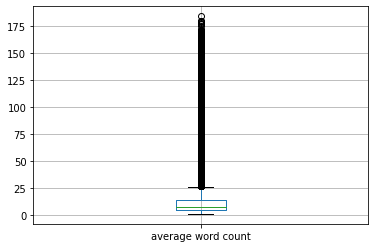

In [ ]:
df.boxplot(column=['average word count'])
plt.show()

In [ ]:
df.drop(find_outliners(df, 'average word count').index.tolist(),  inplace=True)

**12) Removing Special charecters**

In [ ]:
def remove_special_characters(string):
    return re.sub(r'[^\w\s.:,\']', '', string)

df.iloc[:,0] = df.iloc[:,0].apply(remove_special_characters)
df.iloc[:,1] = df.iloc[:,1].apply(remove_special_characters)

**13) Removing rows contain non english words**

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df = df[df['Sentence'].apply(isEnglish) & df['Paraphrase'].apply(isEnglish)]

**Save the results**

In [ ]:
df.to_csv('/content/para-nmt-train.csv', index=False)

# Downloading the Opusparcus Dataset ⏸

In [ ]:
import pandas as pd

In [ ]:
!wget https://korp.csc.fi/download/opusparcus/opusparcus_en.zip

**Unzip Files**

In [ ]:
unzip('/content/opusparcus_en.zip', '/content/data')

In [ ]:
import bz2

def bz2_uncompress(infile, outfile):
    """
    Uncompress a bz2 file.
    """
    with bz2.open(infile, 'rb') as infile:
        with open(outfile, 'wb') as outfile:
            outfile.write(infile.read())

bz2_uncompress('/content/data/opusparcus_v1/en/train/en-train.txt.bz2', '/content/data/opusparcus_v1/en/train/train.txt')

In [ ]:
display_large_file('/content/data/opusparcus_v1/en/train/train.txt', 100)

**Load as a dataframe ⏬**

In [ ]:
df = pd.read_csv('/content/data/opusparcus_v1/en/train/train.txt', sep='\t', header=None)
df.columns = ['indx','Sentence', 'Paraphrase', 'col_0', 'col_1', 'col_2', 'col_3']

In [ ]:
df.drop(['indx', 'col_0', 'col_1', 'col_2', 'col_3'], axis = 1 , inplace=True)

**Remove rows with a high ratio of numbers**

In [ ]:
df['average num ratio'] = df.apply(lambda row: (ratio(row['Sentence']) + ratio(row['Paraphrase']))/2, axis=1)

In [ ]:
df['average num ratio'].mean()

0.0006485831438003348

In [ ]:
df['average num ratio'].std()

0.010614393239631842

In [ ]:
df = df[df.iloc[:,-1]<=0.02]

**Remove Rows with high number of words**

In [ ]:
df['average word count'] = df.apply(lambda row: (count_words(row['Sentence']) + count_words(row['Paraphrase']))/2, axis=1)

In [ ]:
df['average word count'].mean()

In [ ]:
df['average word count'].std()

# Downloading the Paralex Dataset ✊

In [ ]:
!wget http://knowitall.cs.washington.edu/paralex/wikianswers-paraphrases-1.0.tar.gz

**Uncompress tar.gz file**

In [ ]:
import tarfile
import os

def uncompress_tar(file_name, output_dir):
    tar = tarfile.open(file_name)
    tar.extractall(path=output_dir)
    tar.close()

uncompress_tar('/content/wikianswers-paraphrases-1.0.tar.gz', '/content')

In [ ]:
display_large_file('/content/wikianswers-paraphrases-1.0/word_alignments.txt',100)

**Load as a dataframe**

In [ ]:
df = pd.read_csv('/content/wikianswers-paraphrases-1.0/word_alignments.txt', sep='\t', header=None)
df.columns = ['Sentence', 'Paraphrase', 'alignment']

In [ ]:
df.drop(['alignment'],axis=1,inplace=True)

**Removing special charactars**

In [ ]:
import re
def remove_special_characters(string):
    return re.sub(r'[^\w\s.:,?\']', '', string)

df.iloc[:,0] = df.iloc[:,0].apply(remove_special_characters)
df.iloc[:,1] = df.iloc[:,1].apply(remove_special_characters)

**Removing rows containing non-englisg words**

In [ ]:
df = df[df['Sentence'].apply(isEnglish) & df['Paraphrase'].apply(isEnglish)]

**Chunking the dataframe ⛏**

In [ ]:
def chunk_df(df, n):
    """
    Chunk a dataframe into n equal parts.
    """
    return [df.iloc[i::n, :] for i in range(n)]

chunked_df = chunk_df(df, 10)

In [ ]:
chunked_df[0].to_csv('/content/paralex_0.csv')

# Translating

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
from googletrans import Translator
#translator = Translator()

def translate(text):
  translator = Translator()
  translation = translator.translate(text, dest='fa')
  return translation.text

In [ ]:
translate("Der Himmel ist blau und ich mag Bananen")

'آسمان آبی است و من موز را دوست دارم'

In [ ]:
import multiprocessing as mp

def apply_func(df, func=translate):
    df.iloc[:,0] = df.iloc[:,0].apply(func)
    df.iloc[:,1] = df.iloc[:,1].apply(func)
    return df

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = mp.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

num_partitions = 2 #number of partitions to split dataframe
num_cores = 2 #number of cores on your machine

for chunk in pd.read_csv('/content/data/para-nmt-50m/para-nmt-50m-preprocessed.csv', chunksize=100):
  chunk_parallelized = parallelize_dataframe(chunk, apply_func)
  chunk_parallelized.to_csv('/content/data/para-nmt-50m/para-nmt-50m-translated.csv',  index = None, mode='a')

# GitHub

**Generating SSH key**

In [ ]:
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
!cat /root/.ssh/id_rsa.pub

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:PQgsHelrMqNizR+FO1JcQsUgNtXlz/KNVIcDm3kwht0 root@4a7693b4b07c
The key's randomart image is:
+---[RSA 4096]----+
|   +.+*o..o=.    |
|  . +o.+....BE.  |
|    .o+. . + = . |
|    ..=. oo o o  |
|     + oS.o+     |
|    = =   +.o    |
|  oo O     o .   |
|...o. o          |
|..  ..           |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-5e2005f4
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDHznc4DA+fqX/LXFcKutYyiqbgXjJZgis7b95qPk8921NxTG0RzUhI5Jct2KORRRsZ4MemHDbGAQkifkyES/3cM+shrR9aal/K/Bk4uLIUI6oWBUb1oxSeBRD6psoenFO8ipkEDuTrqyqMoPGjdf01M3UMVPRmuh5sAypfVVUs7jGYU73cEZNb0I+ZljgfzdYjf2G7kI4n4xxV/anDoyWQFTegZKPNRfHepoCkDZ1wvOUF2CqIcN4zPKQpQSLS56Homl

In [ ]:
!git config --global user.email "arman.nikkhah.79@gmail.com"
!git config --global user.name "Arman N"

In [ ]:
!git clone git@github.com:IamArmanNikkhah/ParsParaphraser.git

Cloning into 'ParsParaphraser'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [ ]:
!cp '/content/drive/MyDrive/ParsParaphraser/para-nmt-train.csv' '/content/ParsParaphraser'

In [ ]:
%cd '/content/ParsParaphraser'

/content/ParsParaphraser


In [ ]:
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   para-nmt-train.csv



In [ ]:
!git commit -m "Add existing file"

[main 4f82191] Add existing file
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 para-nmt-train.csv


In [ ]:
!git push origin main